In [1]:
from keras.layers import Dense, Input, Lambda, Conv2D, Reshape
from keras.optimizers import adam
from keras.losses import mse
from keras.datasets import mnist, fashion_mnist
from keras.models import Model
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from numpy.random import seed
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
def process(arr):
    arr = arr.astype('float32') / arr.max()
    return arr

x_train = process(x_train)
x_test = process(x_test)

In [5]:
input_shape = (x_train.shape[1], x_train.shape[2])
epsilon_std = 1
filter_num = 10
latent_dim = 3
batch_size = 500
epochs = 50

In [6]:
e_input = Input(shape=input_shape)
e_r = Reshape((input_shape[0], input_shape[1], 1))(e_input)
e_h = Conv2D(filter_num, (5,5), padding="same", activation="relu")(e_r)
e_h = Conv2D(filter_num, (3,3), padding="same", activation="relu")(e_h)
e_r = Reshape((28*28*filter_num, ))(e_h)
e_m = Dense(latent_dim, activation="relu")(e_r)
e_s = Dense(latent_dim, activation="relu")(e_r)

In [7]:
def sample(args):
    z_mean, z_log_sigma = args
    if z_log_sigma.shape[0] > 0:
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
    else:
        epsilon = 0
    return z_mean + z_log_sigma * 0#epsilon

latent_space = Lambda(sample)([e_m, e_s])

In [8]:
d_h = Dense(28*28, activation="relu")(latent_space)
d_r = Reshape((28, 28, 1))(d_h)
d_h = Conv2D(filter_num, (3, 3), padding="same", activation="relu")(d_r)
d_h = Conv2D(filter_num, (5, 5), padding="same", activation="relu")(d_h)
d_o = Conv2D(1, (1, 1), activation="sigmoid")(d_h)
d_out = Reshape((28, 28))(d_o)

In [9]:
cae = Model(e_input, d_out)

encoder = Model(e_input, e_m)

In [13]:
def vae_loss(x, x_decoded_mean):
    K.reshape(x, (28* 28, ))
    K.reshape(x_decoded_mean, (28* 28, ))
    xent_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=1)
    kl_loss = 0.5 * K.sum(K.exp(e_s) + K.square(e_m) - 1. - e_s)
    zero_loss = K.mean(K.square(1 / (K.abs(e_m)+0.01)) / 10)
    return xent_loss + kl_loss + zero_loss

In [14]:
cae.compile(optimizer="adam", loss=vae_loss, metrics=['mae', 'acc'])
cae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 10)   260         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 10)   910         conv2d_1[0][0]                   
__________________________________________________________________________________________________
reshape_2 

In [15]:
history = cae.fit(x_train, x_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(x_test, x_test)
      )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 66us/step - loss: 37.3356 - mean_absolute_error: 0.2510 - acc: 0.2362 - val_loss: 24.1310 - val_mean_absolute_error: 0.1563 - val_acc: 0.1537
Epoch 2/50
60000/60000 [==============================] - 3s 56us/step - loss: 23.7425 - mean_absolute_error: 0.1537 - acc: 0.1336 - val_loss: 23.5181 - val_mean_absolute_error: 0.1531 - val_acc: 0.0996
Epoch 3/50
60000/60000 [==============================] - 3s 56us/step - loss: 23.4393 - mean_absolute_error: 0.1523 - acc: 0.0997 - val_loss: 23.3670 - val_mean_absolute_error: 0.1522 - val_acc: 0.0984
Epoch 4/50
60000/60000 [==============================] - 3s 56us/step - loss: 23.3354 - mean_absolute_error: 0.1520 - acc: 0.0993 - val_loss: 23.3004 - val_mean_absolute_error: 0.1511 - val_acc: 0.0981
Epoch 5/50
60000/60000 [==============================] - 3s 56us/step - loss: 23.2812 - mean_absolute_error: 0.1518 - acc: 0.0661 - val_l

Epoch 41/50
60000/60000 [==============================] - 3s 56us/step - loss: 22.1102 - mean_absolute_error: 0.1294 - acc: 0.0758 - val_loss: 22.0824 - val_mean_absolute_error: 0.1309 - val_acc: 0.0793
Epoch 42/50
60000/60000 [==============================] - 3s 56us/step - loss: 22.0777 - mean_absolute_error: 0.1290 - acc: 0.0765 - val_loss: 22.1060 - val_mean_absolute_error: 0.1266 - val_acc: 0.0719
Epoch 43/50
60000/60000 [==============================] - 3s 56us/step - loss: 22.0678 - mean_absolute_error: 0.1288 - acc: 0.0764 - val_loss: 22.0382 - val_mean_absolute_error: 0.1284 - val_acc: 0.0769
Epoch 44/50
60000/60000 [==============================] - 3s 56us/step - loss: 22.1054 - mean_absolute_error: 0.1292 - acc: 0.0755 - val_loss: 22.0564 - val_mean_absolute_error: 0.1294 - val_acc: 0.0784
Epoch 45/50
60000/60000 [==============================] - 3s 56us/step - loss: 22.0670 - mean_absolute_error: 0.1286 - acc: 0.0759 - val_loss: 22.0385 - val_mean_absolute_error: 0.128

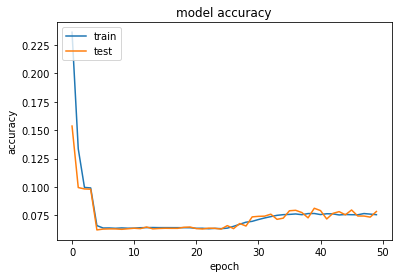

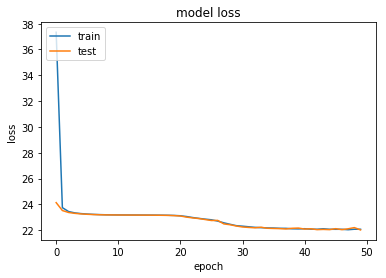

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

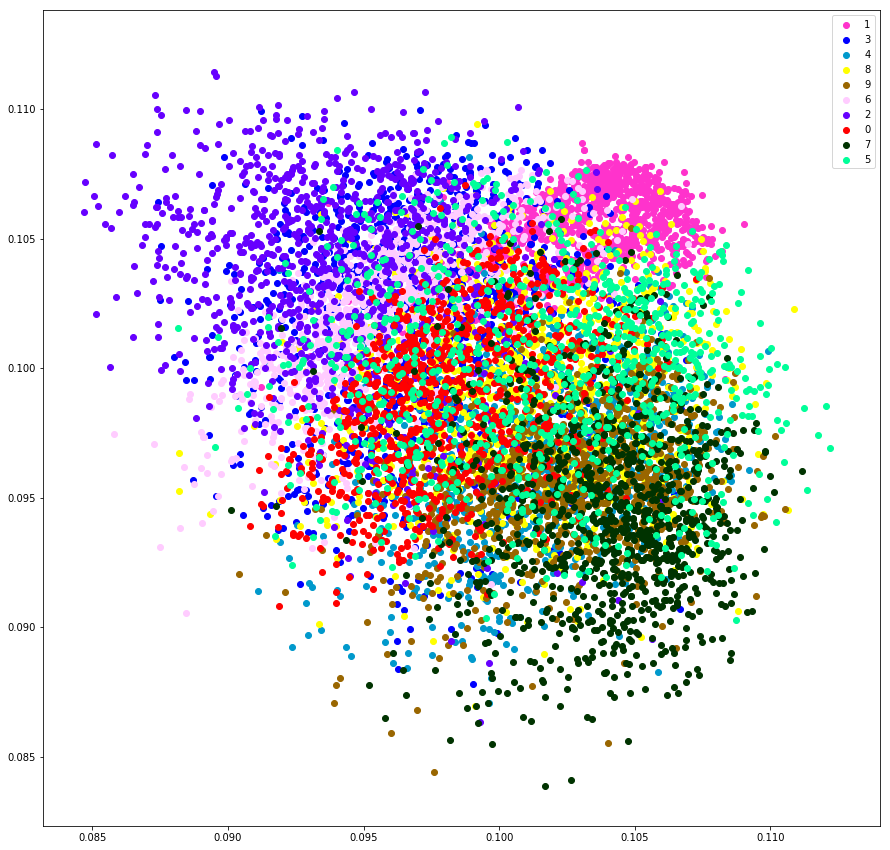

In [17]:
class_map_fashion = {
    0: "T-Shirt",
    1: "Pants",
    2: "Sweater",
    3: "Dress",
    4: "Jacket",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Shoe"
}

class_map_numbers = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9"
}

class_map = class_map_numbers

index_map = {
    class_map[0]: [],
    class_map[1]: [],
    class_map[2]: [],
    class_map[3]: [],
    class_map[4]: [],
    class_map[5]: [],
    class_map[6]: [],
    class_map[7]: [],
    class_map[8]: [],
    class_map[9]: []
}

color_map = {
    class_map[0]: "#ff0000",
    class_map[1]: "#ff33cc",
    class_map[2]: "#6600ff",
    class_map[3]: "#0000ff",
    class_map[4]: "#0099cc",
    class_map[5]: "#00ff99",
    class_map[6]: "#ffccff",
    class_map[7]: "#003300",
    class_map[8]: "#ffff00",
    class_map[9]: "#996600"
}

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
for index, i in enumerate(y_test):
    elem_class = class_map[i]
    elem_list = index_map[elem_class]
    elem_list.append(index)

fig, ax = plt.subplots(figsize=(15, 15))
for elem_class in index_map:
    elems = np.array([x_test_encoded[i] for i in index_map[elem_class]])
    ax.scatter(elems[:, 0], elems[:, 1], c=color_map[elem_class], label=elem_class)
    
ax.legend()
plt.show()

In [18]:
test = 8
img = x_test[test]
print(img.shape)

(28, 28)


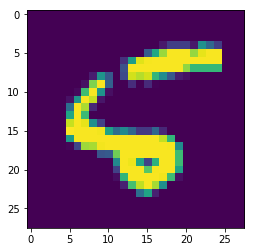

In [19]:
plt.imshow(img.reshape(28, 28))

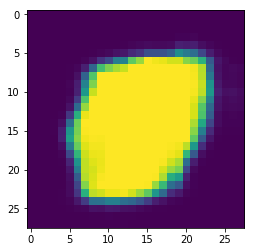

In [20]:
pred = cae.predict(img.reshape(1, 28, 28))
plt.imshow(pred.reshape(28, 28))